In [2]:
import sentiment as sentimentinterface
import classify
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.switch_backend('agg')
import matplotlib.ticker as ticker
%matplotlib inline

import importlib

In [3]:
importlib.reload(sentimentinterface)
print("Reading data")
tarfname = "data/sentiment.tar.gz"
sentiment = sentimentinterface.read_data(tarfname)

Reading data
-- train data
sentiment/train.tsv
4582
-- dev data
sentiment/dev.tsv
458
-- transforming data and labels


In [117]:
sentiment.stop_words = sentimentinterface.generate_stop_words(sentiment, diff = 0.4)

from sklearn.feature_extraction.text import CountVectorizer

sentiment.cv = CountVectorizer(min_df = 3)
sentiment.cv.fit_transform(sentiment.train_data)
sentiment.mindf_stop_words = sentiment.cv.stop_words_
sentiment.cv = CountVectorizer(max_df = 0.2)
sentiment.cv.fit_transform(sentiment.train_data)
sentiment.maxdf_stop_words = sentiment.cv.stop_words_
sentiment.cv = CountVectorizer()
sentiment.cv.fit_transform(sentiment.train_data)
sentiment.training_set_vocabulary = sentiment.cv.vocabulary_

sentimentinterface.vectorize_data(sentiment, stop_words = sentiment.stop_words, max_df = 0.2, min_df = 3)
cls = classify.train_classifier(sentiment.trainX, sentiment.trainy, C = 3.7)

classify.evaluate(sentiment.devX, sentiment.devy, cls, 'dev')
# print("\nReading unlabeled data")
# unlabeled = sentimentinterface.read_unlabeled(tarfname, sentiment)
# print("Writing predictions to a file")
# sentimentinterface.write_pred_kaggle_file(unlabeled, cls, "data/sentiment-pred.csv", sentiment)

  Accuracy on dev is: 0.8187772925764192


0.8187772925764192

### Now cls is the optimized model

In [13]:
sentence = 'i hate this place, it tastes like minwoo'

In [14]:
def vectorize_sentence(sentence, count_vect = sentiment.count_vect):
    return count_vect.transform([sentence])

In [15]:
veccc = vectorize_sentence(sentence)

In [16]:
print(veccc)

  (0, 850)	1.0


In [17]:
sentiment.count_vect.get_feature_names()[850]

'hate'

In [19]:
def predict(sentence, cls = cls):
    sentence_vect = vectorize_sentence(sentence)
    result = cls.predict(sentence_vect)
    if result[0] == 0:
        print("Prediction: NEGATIVE")
    else:
        print("Prediction: POSITIVE")
#     return result

In [41]:
sentence = "Went last night for the first time with my boyfriend. Let me start off by saying I'm vegetarian, but my boyfriend is not. I ordered the chicken v mushroom, it"
print(predict(sentence))

[0]


### Now explain why it predicted 0

#### clean function

In [134]:
def clean(s):
    from string import punctuation
    s_new = []
    s_ignored = []
    res = []
    for c in s:
        if c not in punctuation:
            s_new.append(c.lower())
        else:
            s_new.append(' ')
            
    s = ''.join(c for c in s_new)
    #s = [''.join(c for c in s if c not in punctuation)][0]

    l = s.split()

    for w in l:
        if w in sentiment.count_vect.vocabulary_:
            res.append(w)
        else:
            s_ignored.append(w)
#     l = [w for w in l if w in sentiment.count_vect.vocabulary_]

    return res, s_ignored

#### find stop_words

In [120]:
def find_stop_words(s_ignored):
#     sentence_vect = clean(sentence)
    unseen = []
    maxdf = []
    mindf = []
    oliver_algorithm = []
    for w in s_ignored:
        if w not in sentiment.training_set_vocabulary:
            unseen.append(w)
        if w in sentiment.maxdf_stop_words:
            maxdf.append(w)
        if w in sentiment.mindf_stop_words:
            mindf.append(w)
        if w in sentiment.stop_words:
            oliver_algorithm.append(w)
            
    print("Words being ignored due to not appearing in training set are: ")
    if len(unseen) == 0:
        print("None\n")
    else:
        print(unseen)
        print('')
        
    print("Words being ignored due to mindf (unfrequent in corpus) are: ")
    if len(mindf) == 0:
        print("None\n")
    else:
        print(mindf)
        print('')
        
    print("Words being ignored due to maxdf (too frequent in corpus) are: ")
    if len(maxdf) == 0:
        print("None\n")
    else:
        print(maxdf)
        print('')
        
    print("Words being ignored due to our algorithm are: ")
    if len(oliver_algorithm) == 0:
        print("None\n")
    else:
        print(oliver_algorithm)
        print('')
#     return res


#### find coef

#### Explain the coef

In [24]:
p_dict = {}
n_dict = {}
sentences = sentiment.count_vect.inverse_transform(sentiment.trainX)
for counter in range(0, len(sentiment.train_labels)):
    if sentiment.train_labels[counter] == "POSITIVE":
        for w in sentences[counter]:
            if w in p_dict:
                p_dict[w] += 1
            else:
                p_dict[w] = 1
    else:
        for w in sentences[counter]:
            if w in n_dict:
                n_dict[w] += 1
            else:
                n_dict[w] = 1

In [193]:
def find_coef(sentence_vect, tfidf_vect, stop_words = stop_words, cls = cls, sentiment = sentiment):
    import pandas as pd
#     sentence_vect = clean(sentence)
    word_list = []
    coef_list = []
    num_p_list = []
    num_n_list = []
    tfidf_list = []
    count_list = []
    contribution_list = []
    for word in sentence_vect:
        if word in sentiment.count_vect.vocabulary_:
#             print(word,"\'s coef:\n", cls.coef_[0][sentiment.count_vect.vocabulary_[word]])
            word_list.append(word)
            coef = cls.coef_[0][sentiment.count_vect.vocabulary_[word]]
            coef_list.append(coef)
            tfidf = tfidf_vect.toarray()[0][sentiment.count_vect.vocabulary_[word]]
            tfidf_list.append(tfidf)
            contribution_list.append(coef*tfidf)
            vec = sentiment.cv.transform([sentence])
            count_list.append(vec.toarray()[0][sentiment.training_set_vocabulary[word]])
            if word in p_dict:
                num_p = p_dict[word]
            else:
                num_p = 0
            if word in n_dict:
                num_n = n_dict[word]
            else:
                num_n = 0
#             print("Number of ",word,"in POSITIVE reviews: ",num_p,"\tNumber of ",word,"in NEGATIVE reviews: ",num_n,"\n")
            num_p_list.append(num_p)
            num_n_list.append(num_n)
    dic = {'Feature':word_list, 'Coef':coef_list, 'in POSITIVE':num_p_list,
          'in NEGATIVE':num_n_list, 'tfidf val':tfidf_list, 'Original Count':count_list,
          'Contribution':contribution_list}
    df = pd.DataFrame(dic)
    df = df[['Feature','Contribution','Original Count','tfidf val','Coef','in POSITIVE','in NEGATIVE']]
#     print(df)
    return df

In [191]:
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    try:
        if float(val) < 0:
            color = 'red'
        elif float(val) > 0:
            color = 'green'
        else:
            color = 'black'
#         color = 'red' if float(val) < 0 else 'black'
    except ValueError:
        color = 'black'

    return 'color: %s' % color

def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

In [199]:
def analysis(sentence):
    sentence_vect, s_ignored = clean(sentence)
    tfidf_vect = sentiment.count_vect.transform([sentence])
    find_stop_words(s_ignored)
    print("Remaining words in the vec:")
    print(sentence_vect)
    df = find_coef(sentence_vect, tfidf_vect)
    df = df.style.applymap(color_negative_red, subset=['Coef','Contribution']).\
        apply(highlight_max, subset=['Coef','Contribution']).\
        apply(highlight_min, subset=['Coef','Contribution'])
#     df = df.style.apply(highlight_max)
    return df

### Visualization 

In [230]:
import copy
import math
import matplotlib as mpl

# Logistic Regression Interception
intercept = copy.deepcopy(cls.intercept_)[0]

# Vectorizer vocaulary list (ordered)
cv = sentiment.count_vect.vocabulary_
cv = [(v,w) for w,v in cv.items()]
cv.sort()
cv = [x[1] for x in cv]

def bar_chart(cd, title='',ylabel=''):
    
    words = [w for w,_ in cd.items()]
    coefs = [cd[w] for w in words]
    l = [x for x in zip(coefs, words)]
    l.sort()
    words = [w for c,w in l]
    coefs = [c for c,w in l]

    fig = plt.figure(figsize=(10,5))
    colors = ['red' if c < 0 else 'blue' for c in coefs]
    plt.bar(words, coefs, color=colors)
    plt.xlabel('Word', fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(fontsize=20, rotation=30)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize = 30)
    plt.show()
    
    return fig

def coef_list(words):
    d = {}
    for w in words:
        c = cls.coef_[0][sentiment.count_vect.vocabulary_[w]]
        d[w] = c
        
    return d

def tfidf_x_coef(x):
    
    cd = {}
    for i,v in zip(x.indices, x.data):
        cd[cv[i]] = cls.coef_[0][i] * v
        
    return cd

def prob(x):
    
    z = intercept
    for i,v in zip(x.indices, x.data):
        z += cls.coef_[0][i] * v
        
    pos = 1 / (1 + math.exp(-z))
    neg = 1 - pos
    
    return [neg,pos]

def pie_chart(probs):
    
    mpl.rcParams['font.size'] = 20
    
    fig = plt.figure(figsize=(5,5))
    labels = ["Negative", "Positive"]
    colors = ['red', 'blue']
    explode = (0.1, 0)
    plt.pie(probs, labels=labels, colors=colors,shadow=True, explode=explode,
            autopct='%1.1f%%', startangle=-30)
    plt.axis('equal')
    plt.show()
    
    return fig

def generate_graphs(sentence):
    
    figs = []
    x,y = clean(sentence)
    
    x_vec = sentiment.count_vect.transform([sentence])
    probs = prob(x_vec)
    f3 = pie_chart(probs)
    figs.append(f3)
    
    cd = coef_list(x)
    f1 = bar_chart(cd, 'Words with Coefficients', 'Coefficient')
    figs.append(f1)

    
    cd = tfidf_x_coef(x_vec)
    f2 = bar_chart(cd, 'Words with Tfidfs * Coefficients', 'Tfidf * Coef')
    figs.append(f2)

    
    
    return figs

### Usage

good example:
    TP:  sentiment.train_data[199]
    

In [218]:
sentence = sentiment.train_data[288]

In [219]:
sentence

'What? Last day of Tavern Chips? Corporate Decision?  BIG MISTAKE!  HUGE! UNBELIEVABLE!  Replacement is tater tots? Come on. Really?All Hickory Taverns are awesome!  We love the'

In [221]:
sentiment.trainy[288]

1

In [225]:
predict(sentence)

Prediction: POSITIVE


In [223]:
df = analysis(sentence)
df

Words being ignored due to not appearing in training set are: 
None

Words being ignored due to mindf (unfrequent in corpus) are: 
['replacement', 'tater', 'tots', 'hickory', 'taverns']

Words being ignored due to maxdf (too frequent in corpus) are: 
['of', 'is', 'the']

Words being ignored due to our algorithm are: 
['what', 'last', 'day', 'of', 'chips', 'decision', 'big', 'replacement', 'is', 'come', 'on', 'really', 'all', 'are', 'we', 'the']

Remaining words in the vec:
['tavern', 'corporate', 'mistake', 'huge', 'unbelievable', 'awesome', 'love']


,Feature,Contribution,Original Count,tfidf val,Coef,in POSITIVE,in NEGATIVE
0,tavern,0.300695,1,0.460568,0.652878,3,1
1,corporate,-0.808794,1,0.419748,-1.92686,1,8
2,mistake,-0.603085,1,0.419748,-1.43678,3,6
3,huge,0.334537,1,0.306858,1.0902,43,24
4,unbelievable,0.231096,1,0.473709,0.487843,2,1
5,awesome,1.014,1,0.264331,3.83611,124,15
6,love,0.735123,1,0.216949,3.38845,241,71


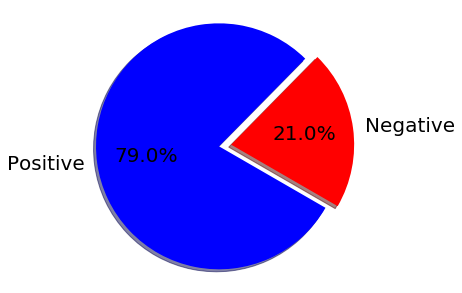

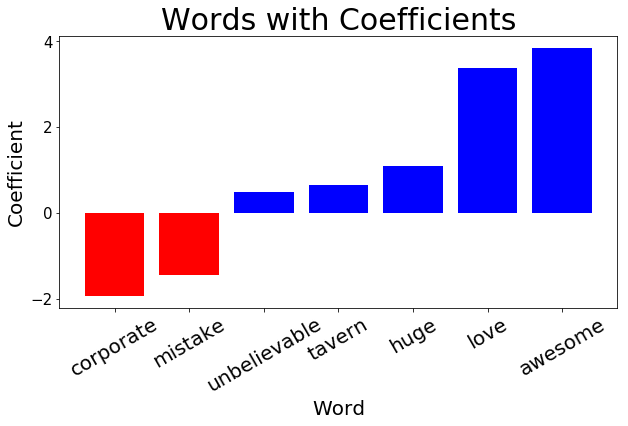

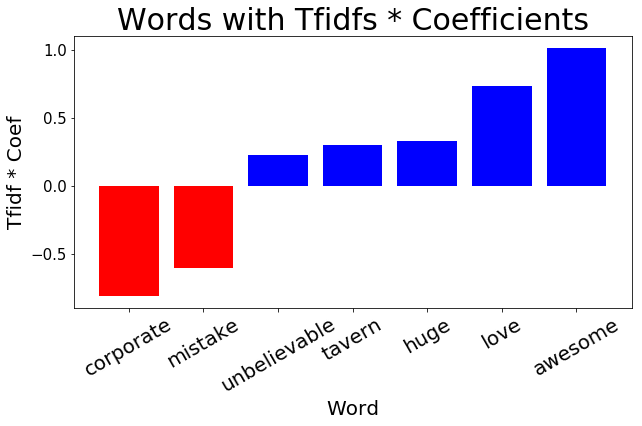

In [231]:
figs = generate_graphs(sentence)

In [217]:
figs

[<Figure size 1080x360 with 1 Axes>,
 <Figure size 1080x360 with 1 Axes>,
 <Figure size 504x504 with 1 Axes>]

### Testing Space

In [108]:
sentiment.cv = CountVectorizer(min_df = 3)

In [106]:
len(sentiment.cv.vocabulary_)

9882

In [107]:
sentiment.cv.stop_words_

set()

In [201]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)

ImportError: No module named 'seaborn'

In [202]:
!pip install seaborn

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
